# See astar graph exploration

In [2]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
from geopy.distance import great_circle
from heapq import heappop, heappush
from itertools import count
import matplotlib.pyplot as plt

from networkx.algorithms.shortest_paths.weighted import _weight_function

import sys
sys.path.append('../../../Multimodal_freight_USA/')

from mfreight.utils import astar_revisited, plot
from mfreight.Multimodal.graph_utils import MultimodalNet

In [3]:
Net = MultimodalNet(path_u="../../../Multimodal_freight_USA/mfreight/Multimodal/data/multimodal_G_tot_u_w_price.plk")

# Build the heuristics 
One must satisty admissbibility. The lower bound for each target weight will be computed. 

### Lower bound condition

### Co2

In [98]:
co2 = [0.05001, 0.01213]
alpha_co2 = max(co2)/min(co2)
print('ratio:',round(alpha_co2,2))

ratio: 4.12


### Price

As the price can have mutiple values, the largest ratio between truckload and multimodal will be selected as the lower bound. Thsi will be the benchmark for the Algorithm speed.

In [95]:
prices = Net.load_price_table()

alpha_price = prices.apply(lambda row: max([row.Intermodal, row.Truckload])/min([row.Intermodal, row.Truckload]),axis=1)
print('ratio:',round(alpha_price[alpha_price == max(alpha_price)],2))
print(prices.loc["('MA', 'CA')"])

ratio: ('MA', 'CA')    1.69
dtype: float64
Intermodal    0.757914
Truckload     1.280281
Name: ('MA', 'CA'), dtype: float64


0.758 will be set to be the lower bound for the heuristics

### Duration (=1/Speed)
Duration is inversly proportionnal to the speed of the arc. Thus we need to find the upper bound of the speed

In [107]:
speed_highways = pd.read_csv("../../../Multimodal_freight_USA/mfreight/Road//data/speed_map_mph.csv",
                       index_col=0)

np.max(speed_highways.values)

75

The slowest value for speed is for Railways ars (10mph)

In [108]:
speed=[10, 75]
print('ratio:',round( max(speed)/min(speed),2))

ratio: 7.5


## Heuristics

In [7]:
def heuristic_func_duration(u,v, G=Net.G_multimodal_u):
    return great_circle((G.nodes[u]['y'],G.nodes[u]['x']),
                        (G.nodes[v]['y'],G.nodes[v]['x'])).miles / 75


def heuristic_func_co2(u,v, G=Net.G_multimodal_u):
    return great_circle((G.nodes[u]['y'],G.nodes[u]['x']),
                       (G.nodes[v]['y'],G.nodes[v]['x'])).miles * 0.01213

def heuristic_func_price(u,v, G=Net.G_multimodal_u):
    return great_circle((G.nodes[u]['y'],G.nodes[u]['x']),
                        (G.nodes[v]['y'],G.nodes[v]['x'])).miles * 0.758

# Build modifed Astar algorithm 
It is always beneficiary to visualize what is happening under the hood. On this modified version of the algorithm

In [6]:
def astar_path(G, source, target, heuristic=None, weight="weight", capture_list=[None], save=False):
    """Modified Astar. 
    Enter a capture_list to show the nodes explorations for the defined Dijkstra rank of the algorithm.
    """
    if source not in G or target not in G:
        msg = f"Either source {source} or target {target} is not in G"
        raise nx.NodeNotFound(msg)

    if heuristic is None:
        def heuristic(u, v):
            return 0

    push = heappush
    pop = heappop
    weight = _weight_function(G, weight)

    c = count()
    queue = [(0, next(c), source, 0, None)]

    enqueued = {}
    explored = {}
    
    counter = 0

    while queue:
        _, rank, curnode, dist, parent = pop(queue)

        if curnode == target:
            path = [curnode]
            node = parent
            while node is not None:
                path.append(node)
                node = explored[node]
            path.reverse()
            return path, explored

        if curnode in explored:
            # Do not override the parent of starting node
            if explored[curnode] is None:
                continue

            # Skip bad paths that were enqueued before finding a better one
            qcost, h = enqueued[curnode]
            if qcost < dist:
                continue

        explored[curnode] = parent
        counter += 1
        
        # Generate plots
        if counter in capture_list:
            print(f'Subgraph_nodes: {len(G.subgraph(explored.keys()))}')
            orig=G.nodes[source]['geometry']
            dest=G.nodes[target]['geometry']
            if save:
                plot.plot_multimodal_path_search(G.subgraph(explored.keys()), orig=orig, dest=dest, save_path=f'Astar{rank}')
            else:
                plot.plot_multimodal_path_search(G.subgraph(explored.keys()), orig=orig, dest=dest, save_path=None)

        for neighbor, w in G[curnode].items():
            ncost = dist + weight(curnode, neighbor, w)
            if neighbor in enqueued:
                qcost, h = enqueued[neighbor]
                if qcost <= ncost:
                    continue
            else:
                h = heuristic(neighbor, target)
            enqueued[neighbor] = ncost, h
            push(queue, (ncost + h, next(c), neighbor, ncost, curnode))

    raise nx.NetworkXNoPath(f"Node {target} not reachable from {source}")

In [114]:
orig = (35.122246, -80.819619) # Charlotte
dest = (39.499301, -104.677064) # Denver

node_orig = ox.get_nearest_node(Net.G_reachable_nodes, orig, method="haversine", return_dist=False)
node_dest = ox.get_nearest_node(Net.G_reachable_nodes, dest, method="haversine", return_dist=False)

Subgraph_nodes: 1
Subgraph_nodes: 300
Subgraph_nodes: 2000
Subgraph_nodes: 3000
Subgraph_nodes: 10000
Subgraph_nodes: 20000


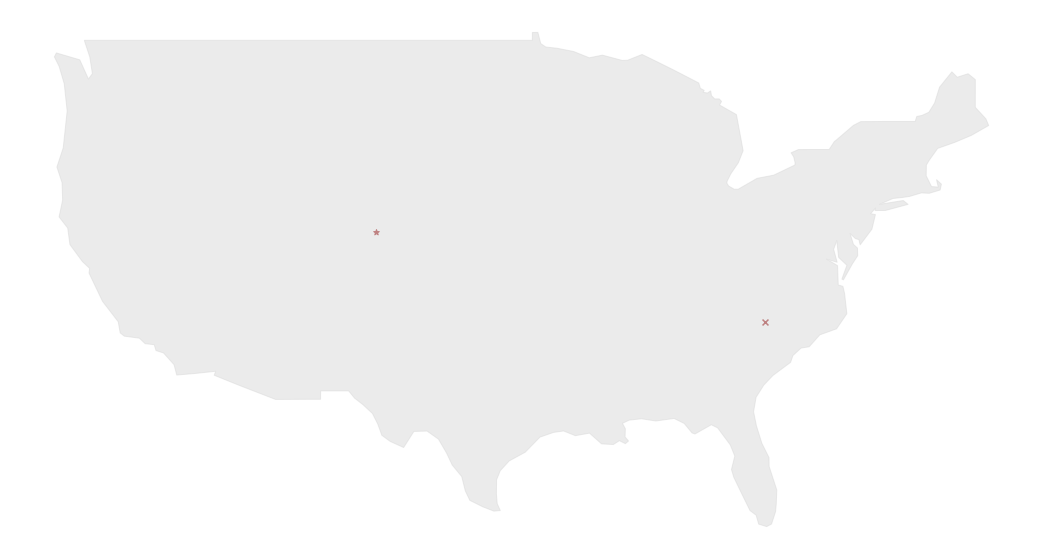

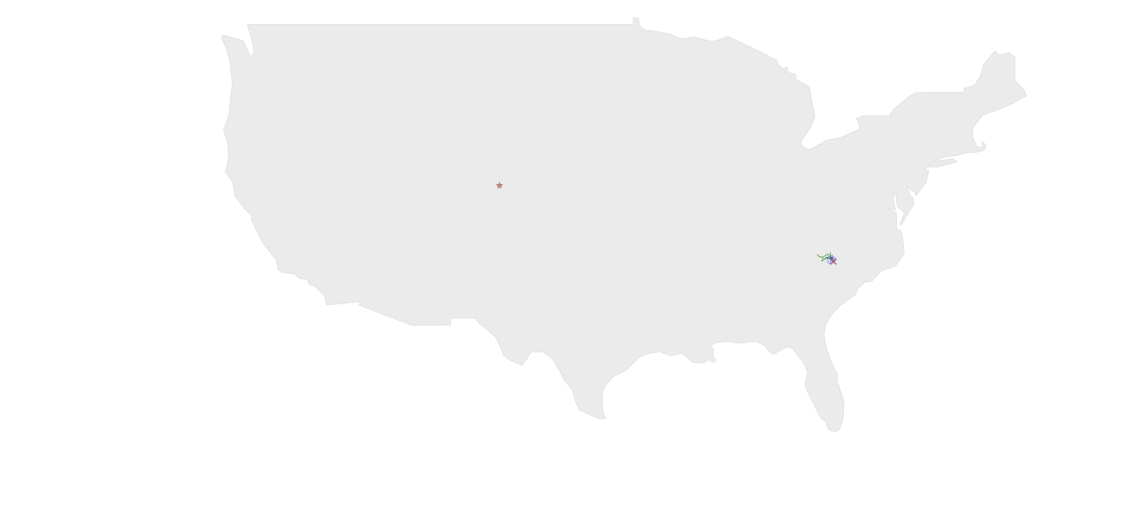

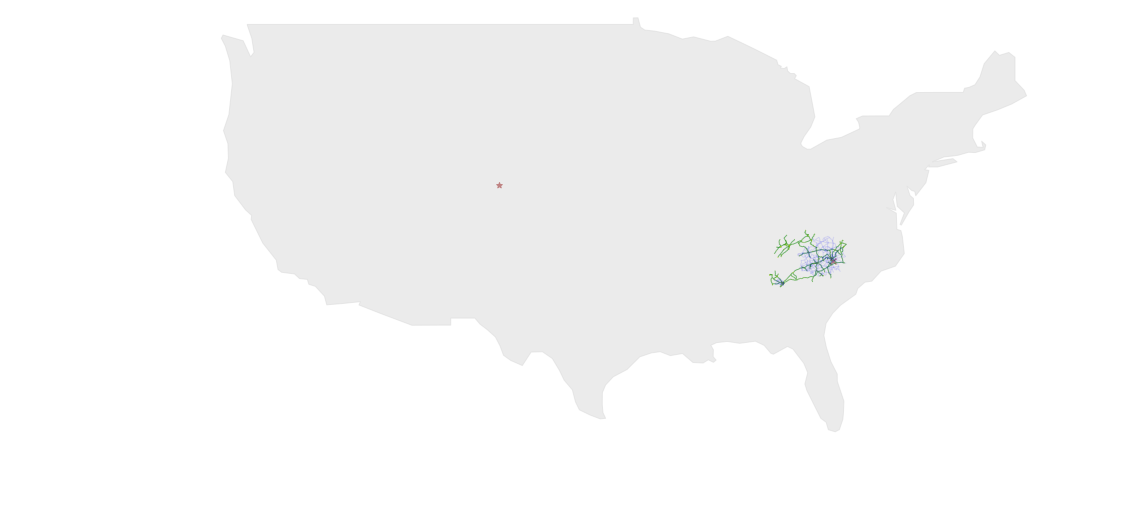

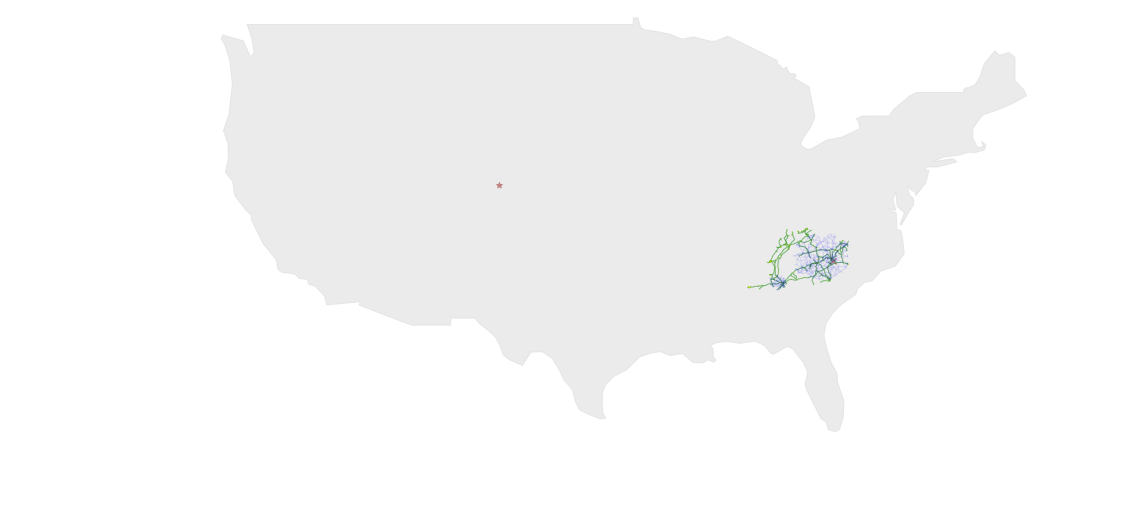

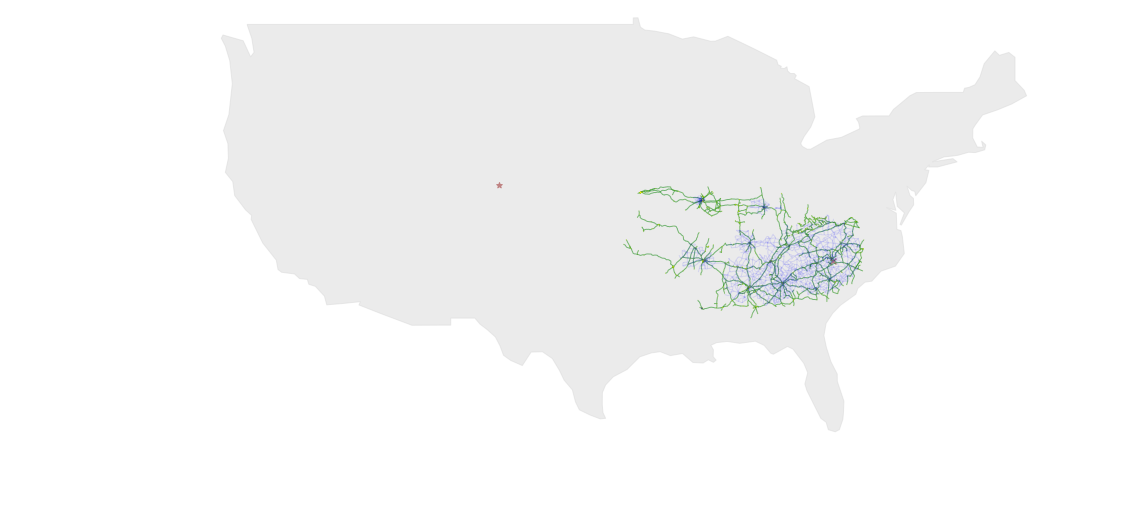

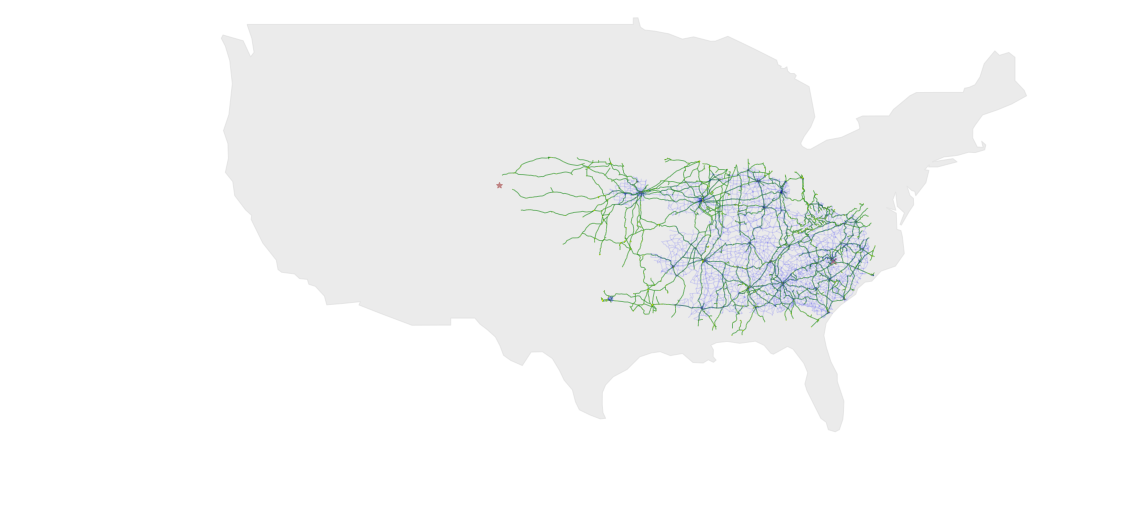

In [115]:
path, explored  = astar_path(Net.G_multimodal_u,
                                  node_orig, node_dest,
                                  heuristic=heuristic_func_price,
                                  weight="('MA', 'CA')",
                                  capture_list=[1,300, 2000, 3000, 10000, 20000, 30000, 66455],
                            save=False) #range(100,30000,400)

In [ ]:
len(explored)

Subgraph_nodes: 1
Subgraph_nodes: 300
Subgraph_nodes: 2000
Subgraph_nodes: 3000
Subgraph_nodes: 9981


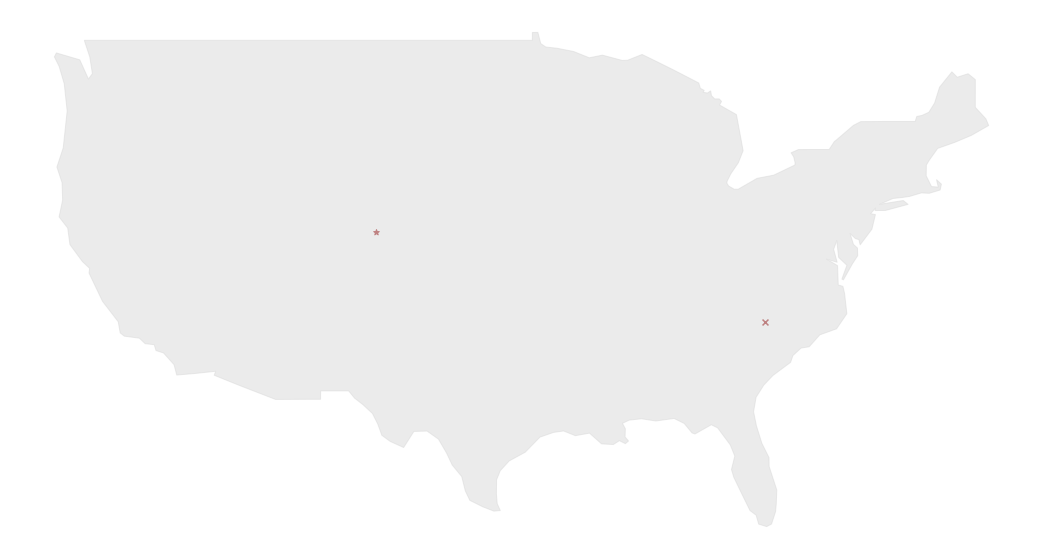

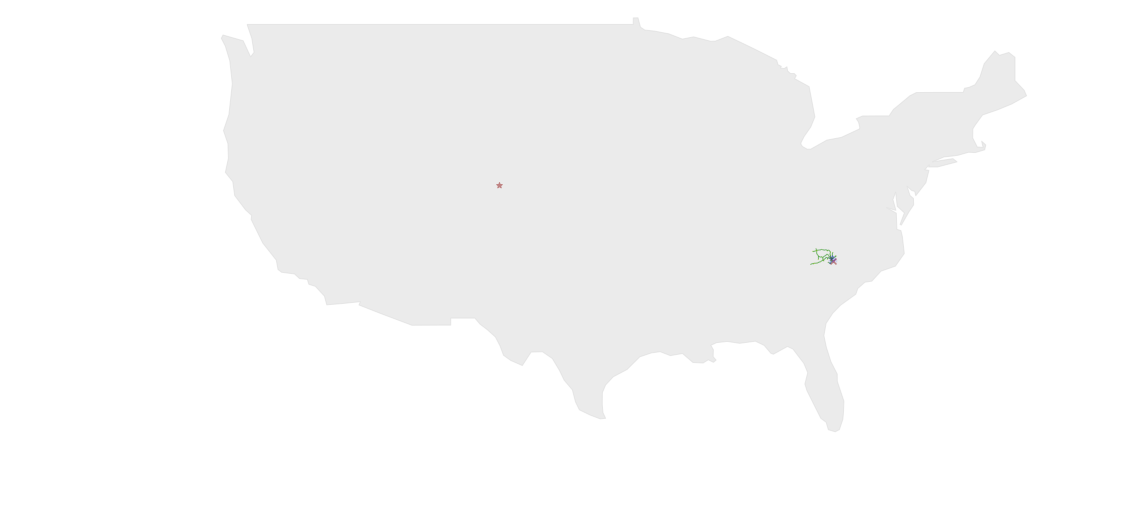

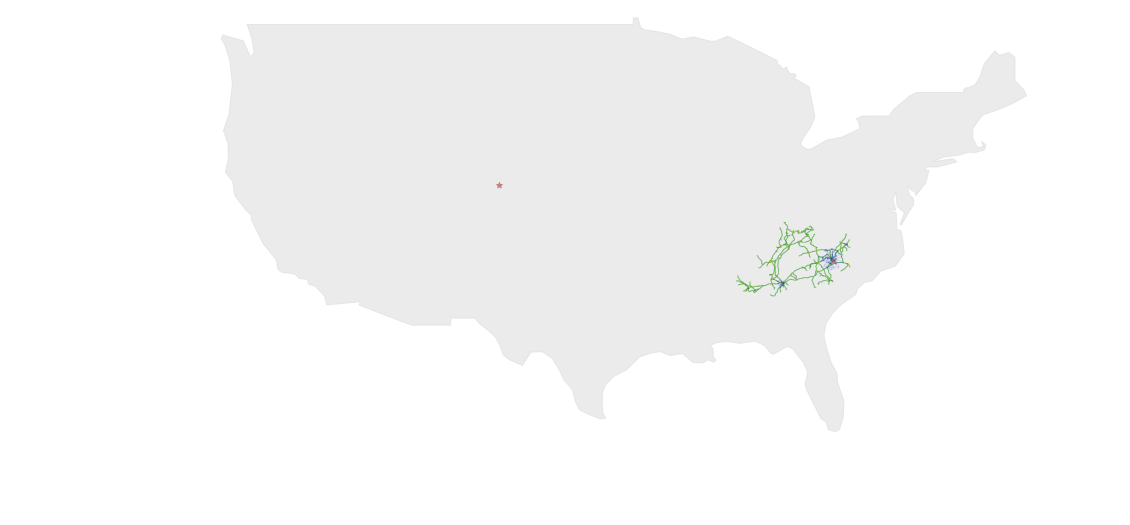

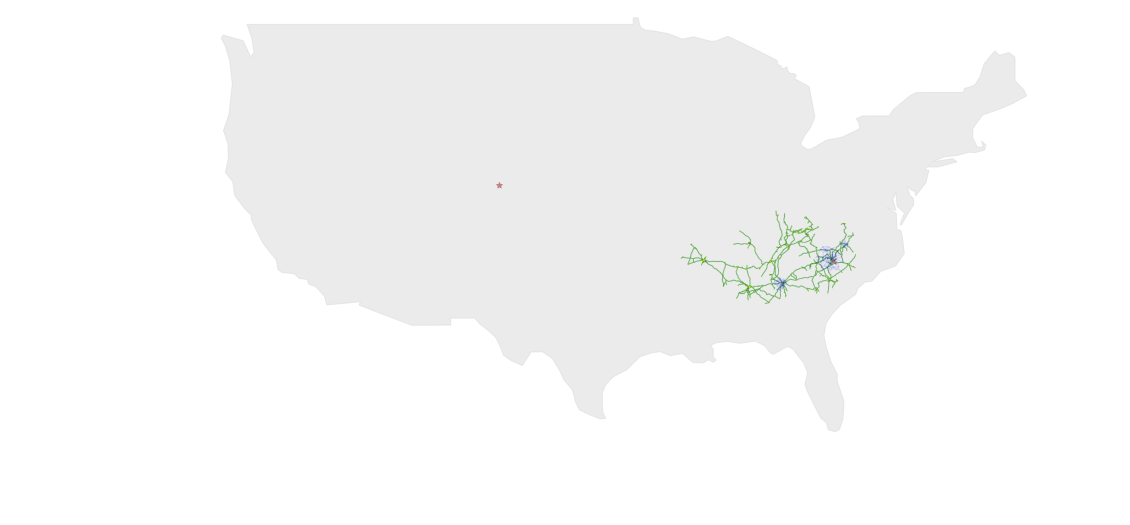

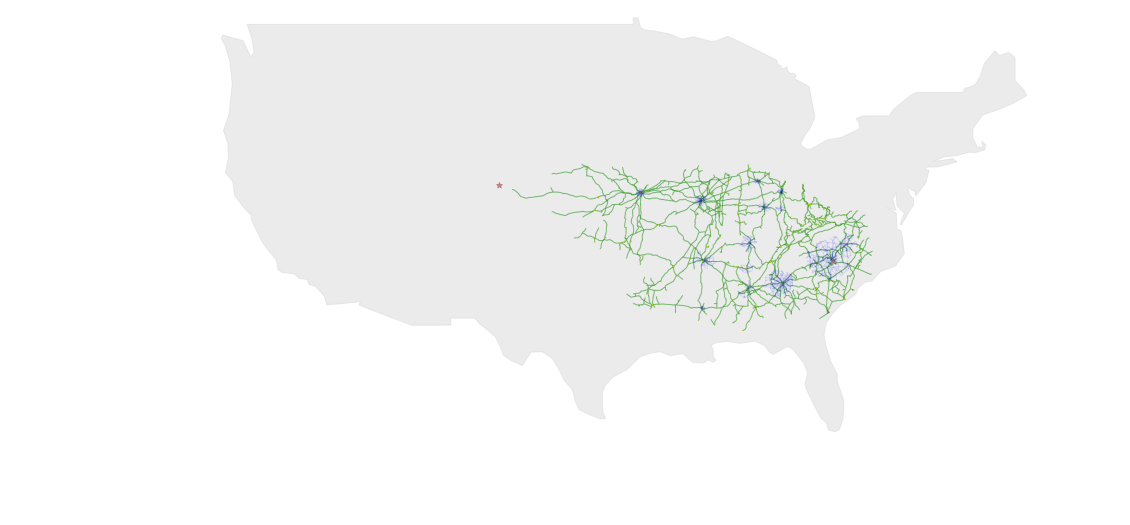

In [116]:
path, explored  = astar_path(Net.G_multimodal_u,
                                  node_orig, node_dest,
                                  heuristic=heuristic_func_co2,
                                  weight="CO2_eq_kg",
                                  capture_list=[1,300, 2000, 3000, 10000, 20000, 30000],
                                save=False) #range(100,30000,400)

In [ ]:
len(explored)

Subgraph_nodes: 1
Subgraph_nodes: 300
Subgraph_nodes: 2000
Subgraph_nodes: 3000
Subgraph_nodes: 10000


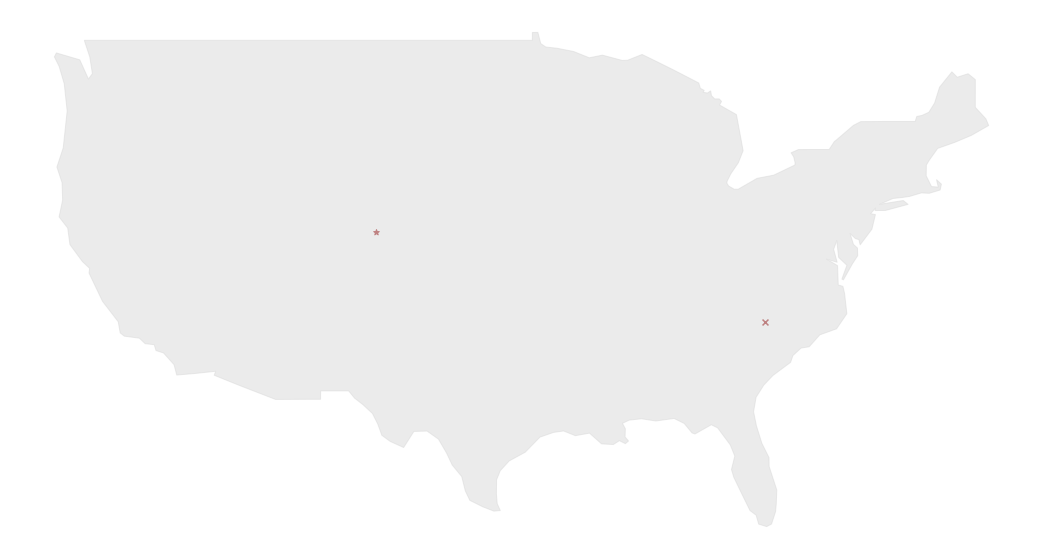

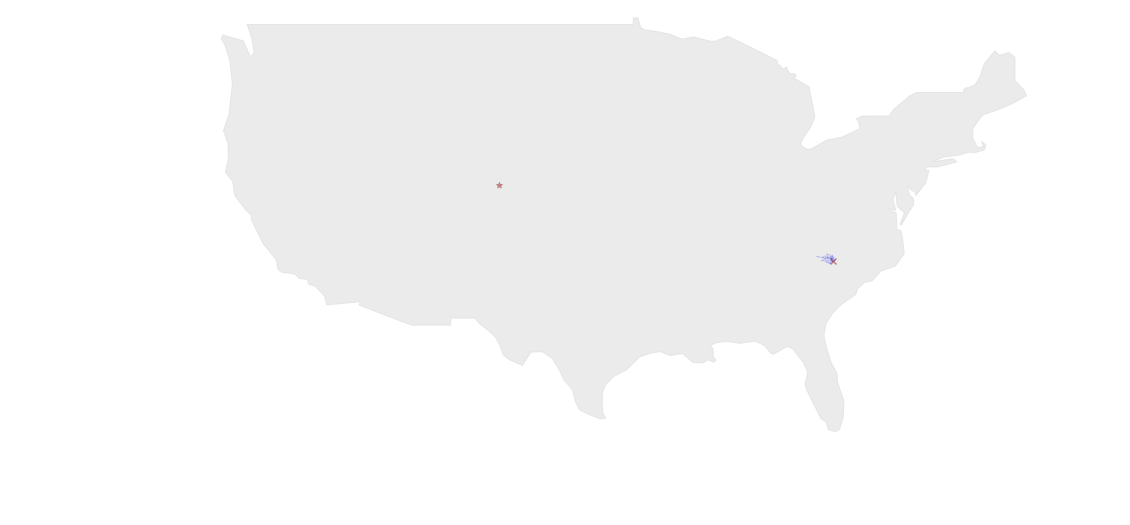

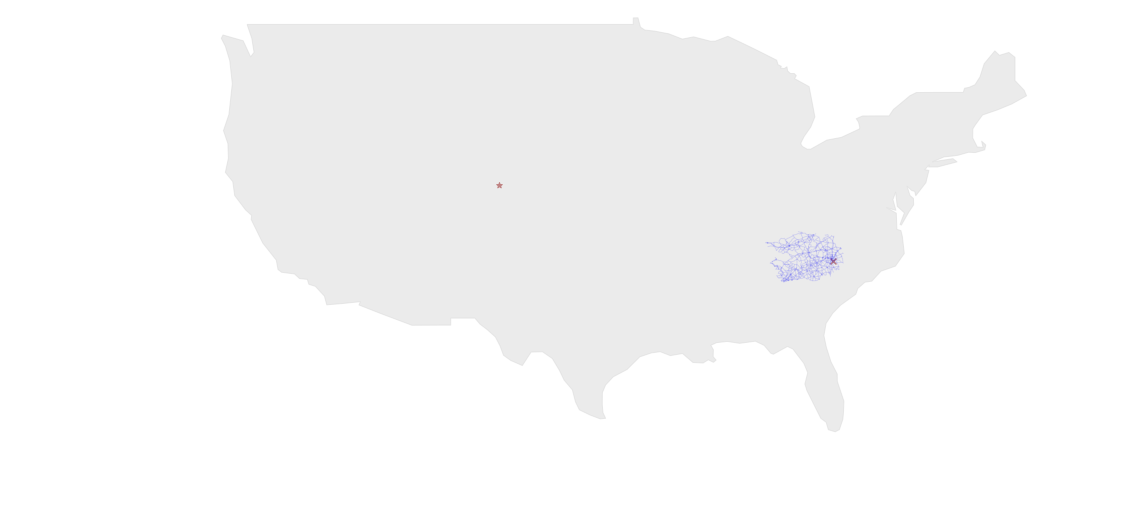

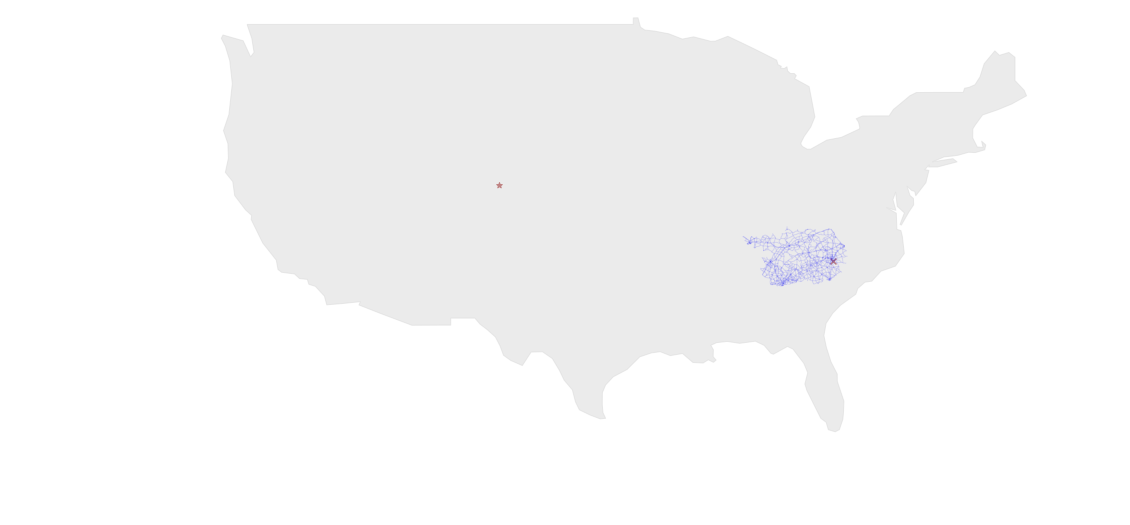

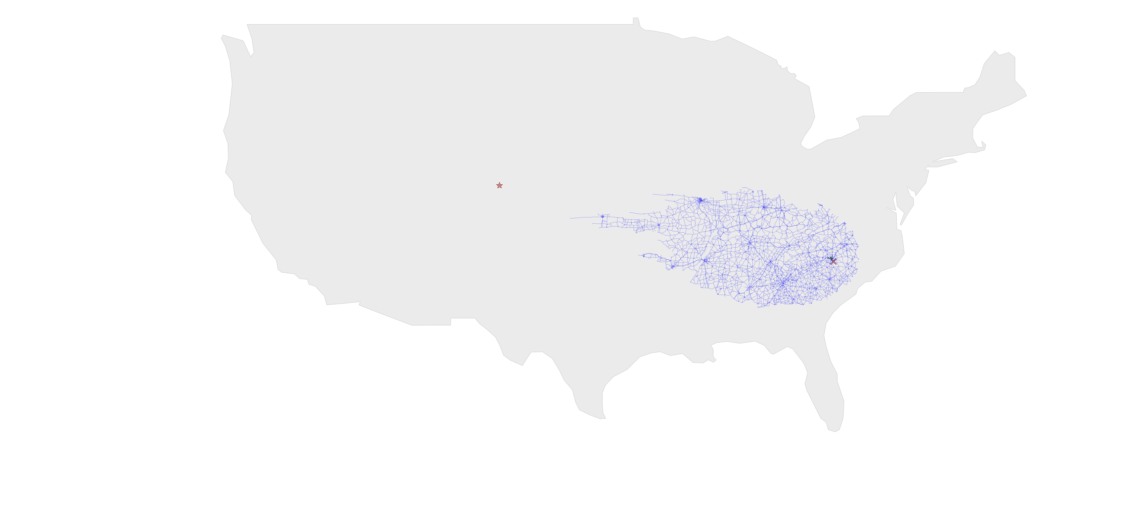

In [117]:
path, explored  = astar_path(Net.G_multimodal_u,
                                  node_orig, node_dest,
                                  heuristic=heuristic_func_duration,
                                  weight="duration_h",
                                  capture_list=[1,300, 2000, 3000, 10000, 20000, 30000],
                                save=False) #range(100,30000,400)

In [80]:
len(explored)

17764

One can see that the number of nodes explored is largely depending on the target weight. Naturally is rail edges have lower weight the number of nodes explored will be significantly lower.